In [1]:
import os
import json
import requests
from typing import List, Any
from IPython.display import display, Markdown, Image

from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq

from langgraph.graph import StateGraph
from typing_extensions import TypedDict


In [2]:
# ===== API Configuration =====
# ຕັ້ງຄ່າ API Keys
GROQ_API_KEY = os.getenv("GROQ_API_KEY")  # ໃສ່ Groq API key
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")  # ໃສ່ Tavily API key  
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")  # ໃສ່ Weather API key (OpenWeatherMap)

# ຕັ້ງຄ່າ environment variables
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [3]:
# ===== Tools Definition =====
@tool
def get_weather(city: str) -> str:
    """ເອົາຂໍ້ມູນສະພາບອາກາດຂອງເມືອງທີ່ກຳນົດ"""
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": city,
        "appid": WEATHER_API_KEY,
        "units": "metric",
        "lang": "en"
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        weather_info = {
            "city": data["name"],
            "country": data["sys"]["country"],
            "temperature": data["main"]["temp"],
            "feels_like": data["main"]["feels_like"],
            "humidity": data["main"]["humidity"],
            "description": data["weather"][0]["description"],
            "wind_speed": data["wind"]["speed"]
        }
        
        return json.dumps(weather_info, ensure_ascii=False)
    except Exception as e:
        return f"ບໍ່ສາມາດເອົາຂໍ້ມູນສະພາບອາກາດໄດ້: {str(e)}"

# ສ້າງ Tavily search tool
search_tool = TavilySearchResults(max_results=3)

# ລາຍການເຄື່ອງມືທັງໝົດ - ແບບງ່າຍໆ
tools = [get_weather, search_tool]

C:\Users\Dell\AppData\Local\Temp\ipykernel_34776\3673448080.py:33: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3)


In [4]:
 # Manual tool execution function
def execute_tools(tool_calls, available_tools):
    """set up tool execution"""
    tools_dict = {tool.name: tool for tool in available_tools}
    results = []
    
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        if tool_name in tools_dict:
            try:
                result = tools_dict[tool_name].invoke(tool_args)
                results.append(
                    ToolMessage(
                        content=str(result),
                        tool_call_id=tool_id
                    )
                )
            except Exception as e:
                results.append(
                    ToolMessage(
                        content=f"Error executing {tool_name}: {str(e)}",
                        tool_call_id=tool_id
                    )
                )
        else:
            results.append(
                ToolMessage(
                    content=f"Tool {tool_name} not found",
                    tool_call_id=tool_id
                )
            )
    
    return results

In [5]:
# ===== LLM Setup =====
llm = ChatGroq(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0,
    max_tokens=1024
)

# Assign tools ເຂົ້າກັບ LLM 
llm_with_tools = llm.bind_tools(tools)

In [6]:
# ===== State Definition =====
class AgentState(TypedDict):
    messages: List[Any]
    next_action: str

# ===== Agent Functions =====
def should_continue(state: AgentState) -> str:
    """ກຳນົດວ່າຄວນສືບຕໍ່ການທຳງານຫຼືຢຸດ"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # ຖ້າຂໍ້ຄວາມສຸດທ້າຍບໍ່ໄດ້ເອີ້ນໃຊ້ tool ແມ່ນສິ້ນສຸດ
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return "end"
    else:
        return "continue"

def call_model(state: AgentState):
    """ເອີ້ນ LLM ເພື່ອສ້າງຄຳຕອບ"""
    messages = state["messages"]
    
    # System prompt ສຳລັບ ReAct pattern
    system_prompt = """ເຈົ້າແມ່ນ AI Assistant ທີ່ສາມາດໃຊ້ເຄື່ອງມືຕ່າງໆໄດ້.

ເຈົ້າມີເຄື່ອງມື 2 ຢ່າງ:
1. get_weather - ສຳລັບເອົາຂໍ້ມູນສະພາບອາກາດ
2. tavily_search_results_json - ສຳລັບຄົ້ນຫາຂໍ້ມູນທົ່ວໄປ

ເມື່ອຜູ້ໃຊ້ຖາມ, ໃຫ້ເຈົ້າປະຕິບັດຕາມ ReAct pattern:
1. Reason - ວິເຄາະຄຳຖາມແລະຄິດວ່າຕ້ອງເຮັດຫຍັງ
2. Act - ໃຊ້ເຄື່ອງມືທີ່ເໝາະສົມ
3. Observe - ສັງເກດຜົນລັບຈາກເຄື່ອງມື
4. ທຳຊ້ຳຈົນກວ່າຈະໄດ້ຄຳຕອບທີ່ສົມບູນ

ຄຳຕອບສຸດທ້າຍໃຫ້ເປັນພາສາລາວ ແລະ ໃຫ້ຄຳຕອບທີ່ເປັນປະໂຫຍດແລະຊັດເຈນ."""

    # ເພີ່ມ system message
    full_messages = [{"role": "system", "content": system_prompt}] + messages
    
    # ໃຊ້ llm_with_tools ທີ່ມີ tools
    response = llm_with_tools.invoke(full_messages)
    return {"messages": [response]}

def call_tools(state: AgentState):
    """ເອີ້ນໃຊ້ເຄື່ອງມືຕາມທີ່ LLM ຮ້ອງຂໍ"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # ກວດສອບວ່າມີ tool_calls ຫຼືບໍ່
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        tool_results = execute_tools(last_message.tool_calls, tools)
        return {"messages": tool_results}
    
    return {"messages": []}

# ===== Graph Construction =====
def create_react_agent():
    """ສ້າງ ReAct Agent Graph ແບບງ່າຍ"""
    workflow = StateGraph(AgentState)
    
    # ເພີ່ມ nodes
    workflow.add_node("agent", call_model)
    workflow.add_node("tools", call_tools)
    
    # ຕັ້ງ entry point
    workflow.set_entry_point("agent")
    
    # ເພີ່ມ conditional edges
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "continue": "tools",
            "end": "__end__"  # ໃຊ້ string ແທນ END constant
        }
    )
    
    # ເພີ່ມ edge ຈາກ tools ກັບຄືນ agent
    workflow.add_edge("tools", "agent")
    
    return workflow.compile()

# ===== Main Execution =====
def run_agent(query: str):
    """ແລ່ນ Weather Agent ດ້ວຍຄຳຖາມທີ່ໃຫ້ມາ"""
    agent = create_react_agent() 
    
    # ສ້າງ initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "next_action": ""
    }
    
    print(f"🤖 Processing query: {query}\n")
    
    # ແລ່ນ agent
    result = agent.invoke(initial_state)
    
    # ສະແດງຜົນໄຟນອນ
    final_response = result["messages"][-1].content
    
    # ສະແດງໃນຮູບແບບ Markdown
    display(Markdown(f"## ຄຳຕອບຈາກ AI Agent\n\n{final_response}"))
    
    return result

🚀 ເລີ່ມຕົ້ນ ReAct Agent...

📊 ສະແດງ Agent Graph:


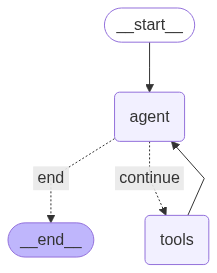


📍 ທົດສອບການເອົາຂໍ້ມູນສະພາບອາກາດ
🤖 Processing query: ສະພາບອາກາດໃນນະຄອນຫລວງວຽງຈັນແນວໃດ?



## ຄຳຕອບຈາກ AI Agent

ຂໍ້ມູນສະພາບອາກາດຂອງນະຄອນຫຼວງວຽງຈັນໃນປະຈຸບັນແມ່ນມີອຸນຫະພູມ 27.57 ອົງສາເຊ, ຄວາມຊື່ນພີ່ນ 91%, ສະພາບອາກາດມີເມກໜາໝອກ, ຄວາມໄວລົມ 0.72 ແມັດ/ວິນາທີ. ອຸນຫະພູມຮູ້ສຶກວ່າ 32.56 ອົງສາເຊ.


🎮 ທົດສອບການຄົ້ນຫາຂໍ້ມູນເກມ
🤖 Processing query: ເກມ PS5 ເດືອນ 9 ມີເກມຍັງອອກມາໃຫມ່



## ຄຳຕອບຈາກ AI Agent

ເກມ PS5 ທີ່ກຳລັງຈະມາໃນປີ 2025 ມີຫຼາຍເກມທີ່ໜ້າຕື່ນເຕັ້ນ, ບາງເກມທີ່ນຶ່ງສົນໃຈແມ່ນ:
- Gears of War Reloaded - ວັນທີ 26 ສິງຫາ 2025
- Metal Solid Delta: Snake Eater - ວັນທີ 28 ສິງຫາ 2025
- Borderlands 4 - ວັນທີ 23 ກັນຍາ 2025
- Silent Hill F - ວັນທີ 25 ກັນຍາ 2025
- Ghost of Yōtei - ວັນທີ 2 ຕຸລາ 2025

ຜູ້ໃຊ້ສາມາດຕິດຕາມຂໍ້ມູນເກມໃໝ່ໆ ໄດ້ຈາກແຫຼ່ງຂໍ້ມູນທີ່ເຊື່ອຖືໄດ້ ເຊັ່ນ TechRadar, Push Square ແລະ GamesRadar.

In [7]:
if __name__ == "__main__":
    # ຕົວຢ່າງການນຳໃຊ້ງານ
    print("🚀 ເລີ່ມຕົ້ນ ReAct Agent...")

    # ສ້າງ agent ເພື່ອສະແດງ graph
    agent = create_react_agent()
    
    # ສະແດງ graph ຄັ້ງດຽວ
    print("\n📊 ສະແດງ Agent Graph:")
    try:
        display(Image(agent.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"ບໍ່ສາມາດສະແດງ graph ໄດ້: {e}")
    
    # ຄຳຖາມທຳອິດ - ສະພາບອາກາດ
    print("\n" + "="*60)
    print("📍 ທົດສອບການເອົາຂໍ້ມູນສະພາບອາກາດ")
    print("="*60)
    result1 = run_agent("ສະພາບອາກາດໃນນະຄອນຫລວງວຽງຈັນແນວໃດ?")
    
    # ຄຳຖາມທີສອງ - ເກມ PS5
    print("\n" + "="*60) 
    print("🎮 ທົດສອບການຄົ້ນຫາຂໍ້ມູນເກມ")
    print("="*60)
    result2 = run_agent("ເກມ PS5 ເດືອນ 9 ມີເກມຍັງອອກມາໃຫມ່")
    